In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from preprocessing import *

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# from src.kneighborRegressor import *
# from src.regression_grids import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="cgreGFP"


In [3]:
recompute=False
# True: retrain all models
# False: try loading saved models, otherwise retrain models

Import modules
Define functions
Load cgreGFP data
cgreGFP 236 aa


D:\AppData\Temp\ipykernel_37460\3746610603.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_record[brightness_col]=np.log10(wt_record[brightness_col])


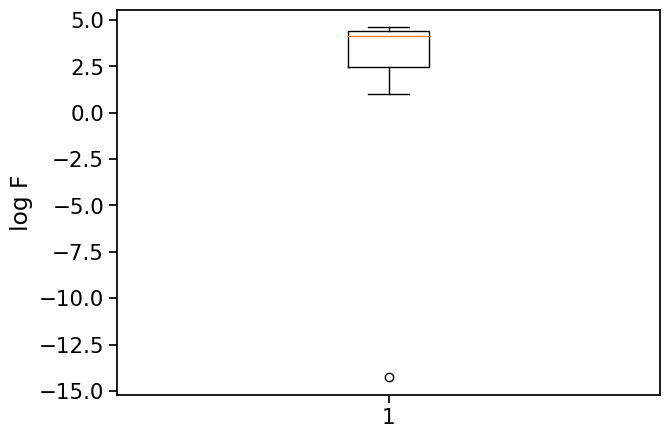

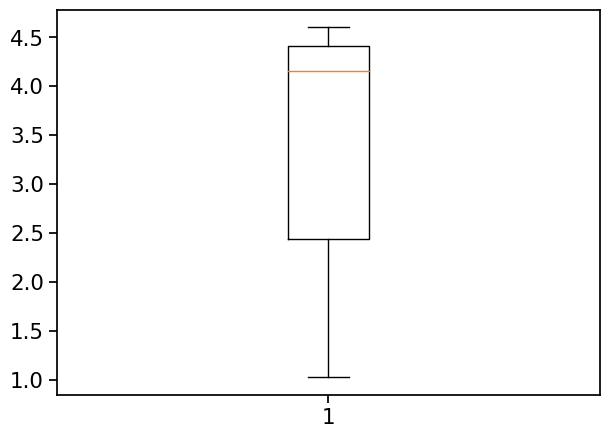

Pre-processing cgreGFP
Load cgreGFP encodings
Split train, valid, test sets
train_index 14199
valid_index 4733
test_index 4733


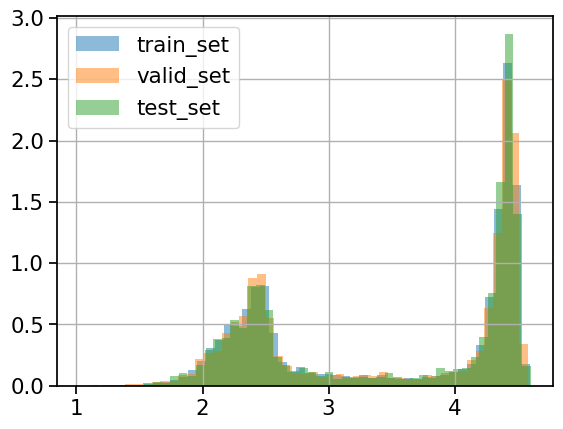

In [4]:
showmatrix=False
%run 01_preprocessing.ipynb

#### Load ESM Model

In [5]:
def load_esm_model(model_name,device=0):
  repr_layer = int(model_name.split('_')[1][1:])
  model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
  batch_converter = alphabet.get_batch_converter()
  return model.eval().to(device),alphabet,batch_converter,repr_layer

# Load model
model,alphabet,batch_converter,repr_layer = load_esm_model(model_name='esm2_t33_650M_UR50D',device='cpu')


Using cache found in C:\Users\u242841/.cache\torch\hub\facebookresearch_esm_main


In [6]:
# df = df.head(20)
# df

In [7]:
genes = df["aa_genotype_native"]
embeddings = []; input_df_ids = []

device="cpu"

for gene in genes:
    # Directly access the sequence associated with the gene
    sequence = df.loc[df["aa_genotype_native"] == gene, "full_seq"].iloc[0][:-1] #remove final stop codon
    dt = [(gene, sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(dt)
    with torch.no_grad():
        results_ = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)['representations'][33]

    input_df_ids.append(gene)
    embeddings.append(results_)
target = df[[brightness_col]]
print(target)
len(embeddings)

# Assuming 'embeddings' is the tensor you obtained from the ESM model
# embeddings_new = embeddings.cpu().numpy()  # Move to CPU and convert to NumPy
embeddings_new = torch.stack(embeddings).cpu().numpy()

# Example of averaging embeddings across the sequence length
features = embeddings_new.mean(axis=1)  # Averages across the sequence_length dimension

# Now 'features' is a 2D NumPy array suitable for scikit-learn
# Average across the sequence length (axis=1) to get a 2D array
features_2d = features.mean(axis=1)
print(features_2d.shape)


       replicates_mean_brightness
13                       2.299773
14                       2.425549
15                       1.976627
16                       2.080940
17                       2.475661
...                           ...
92360                    2.840796
92363                    2.460343
92372                    2.261105
92384                    2.455826
92386                    4.495728

[23665 rows x 1 columns]
(23665, 1280)


In [8]:
predictors = pd.DataFrame(features_2d,index=target.index)

#### Split train/valid/test

Split train, valid, test sets
train_index 14199
valid_index 4733
test_index 4733


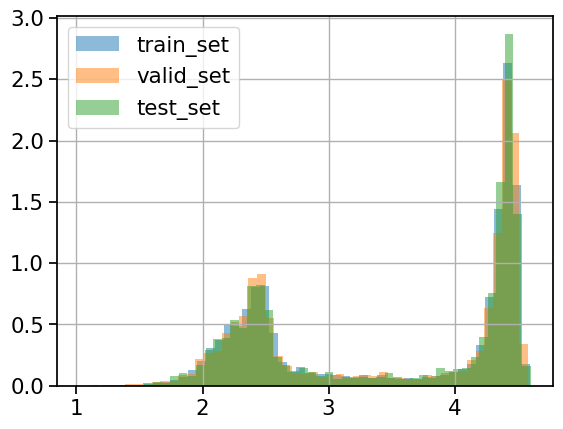

In [9]:
# First split train, valid, test indexes (not very elegant, yes)
print("Split train, valid, test sets")

(predictors_train,
predictors_valid_test, 
target_train, 
target_valid_test) = train_test_split(df.index, 
                                     df.index, 
                                     test_size=0.4, 
                                     random_state=42)

(predictors_valid, 
predictors_test, 
target_valid,
target_test) = train_test_split(predictors_valid_test, 
                               target_valid_test, 
                               test_size=0.5, 
                               random_state=42)

train_index = sorted(predictors_train)
valid_index = sorted(predictors_valid)
test_index  = sorted(predictors_test)

# if encodings have been loaded, 
# split predictors and target data according to indexes above
if load_encodings:
    
    predictors_train = predictors.loc[train_index]
    predictors_valid = predictors.loc[valid_index]
    predictors_test = predictors.loc[test_index]

    target_train = target.loc[train_index]
    target_valid = target.loc[valid_index]
    target_test = target.loc[test_index]
    
    print("train_index",len(train_index))
    print("valid_index",len(valid_index))
    print("test_index",len(test_index))

    #------------------------------------------------------------
    # check subset sizes and medianBrightness distributions (using density parameter)
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('w')
    
    target_train[brightness_col].hist(alpha=0.5, density=True, bins=50)
    target_valid[brightness_col].hist(alpha=0.5, density=True, bins=50)
    target_test[brightness_col].hist(alpha=0.5, density=True, bins=50)

    # Add a legend
    plt.legend(["train_set", "valid_set", "test_set"])

    # Show the plot
    plt.show()

In [17]:
predictors_train.to_csv('predictors_train.csv', index=False)
target_train.to_csv('target_train.csv', index=False)

predictors_valid.to_csv('predictors_valid.csv', index=False)
target_valid.to_csv('target_valid.csv', index=False)

predictors_test.to_csv('predictors_test.csv', index=False)
target_test.to_csv('target_test.csv', index=False)


## Train
Train best architechture from Orthologous GFP Fitness Peaks 
using a EMS embedding instead of their one-hot encodding

In [20]:
def make_model():
    inputs = Input(shape=(predictors_train.shape[1],))
    hidden1 = Dense(int(best_Hparams["neurons_in_1st_h_layer"]),activation="linear")(inputs)
    dropout1 = Dropout(dropout_rate,name="D1")(hidden1,training=True)
    hidden2 = Dense(int(best_Hparams["neurons_in_2nd_h_layer"]),activation="sigmoid")(dropout1)
    dropout2 = Dropout(dropout_rate,name="D2")(hidden2,training=True)
    predictions = Dense(1,activation="linear")(dropout2)
    
    optimizer = keras.optimizers.Adam()
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=['mae'])
    return(model)

## train their best architecture wiht EMS encodding

In [26]:
dropout_rate = 0.1
optimizer = keras.optimizers.Adam()

def optimize_model(x_train, y_train, x_val, y_val, params):
    
    def fitted_model(x_train, y_train, x_val, y_val, params):
        
        inputs = Input(shape=(predictors_train.shape[1],))
        hidden1 = Dense(int(params["neurons_in_1st_h_layer"]),activation="linear",name="L1")(inputs)
        dropout1 = Dropout(dropout_rate,name="D1")(hidden1)
        hidden2 = Dense(int(params["neurons_in_2nd_h_layer"]),activation="sigmoid",name="L2")(dropout1)
        dropout2 = Dropout(dropout_rate,name="D2")(hidden2)
        predictions = Dense(1,activation="linear")(dropout2)        
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=optimizer,loss="mean_squared_error",metrics=['mae'])

        out = model.fit(x_train,y_train,
                        validation_data=[x_val,y_val],
                       epochs=20,
                       shuffle=True)

        return out, model

    scan_object = talos.Scan(x=x_train,
                             y=y_train,
                             x_val=x_val,
                             y_val=y_val,
                             model=fitted_model,
                             experiment_name="fit N-N-1",
                             params=params,
                             fraction_limit=0.1,
                             reduction_metric='val_loss',
                             minimize_loss=True,
                             print_params=True,
                             random_method="quantum")

    return scan_object

In [28]:
# create parameter dict
params = {}
params["neurons_in_1st_h_layer"] = [*range(1,11)]+[20,50,100,200]
params["neurons_in_2nd_h_layer"] = [*range(1,11)]+[20,50,100,200]

In [30]:

opt_file = modelsPath+gene_name+"_talos_optim.csv"

try: 
    optimisation_results = pd.read_csv(opt_file)
    
except:
    optimisation_results = optimize_model(x_train=predictors_train.values,
                                          y_train=target_train.values,
                                          x_val=predictors_valid.values,
                                          y_val=target_valid,
                                          params=params)
    
    optimisation_results.data.to_csv(opt_file)
    optimisation_results = pd.read_csv(opt_file)

In [31]:
best_Hparams = optimisation_results.loc[optimisation_results["val_loss"].argmin(),:]
best_Hparams

Unnamed: 0                  4.000000
round_epochs               10.000000
val_loss                    0.187551
val_mae                     0.242268
loss                        0.183471
mae                         0.294642
neurons_in_1st_h_layer    200.000000
neurons_in_2nd_h_layer    200.000000
Name: 4, dtype: float64

_04_Models/cgreGFP_N1_N2_1_NN_optimized_EMSencoding.h5
Epoch 1/100
142/142 [==============================] - 1s 7ms/step - loss: 1.3928 - mae: 1.0179 - val_loss: 1.0284 - val_mae: 0.9380
Epoch 2/100
142/142 [==============================] - 1s 6ms/step - loss: 1.0127 - mae: 0.9313 - val_loss: 1.0082 - val_mae: 0.9115
Epoch 3/100
142/142 [==============================] - 1s 6ms/step - loss: 0.9760 - mae: 0.9126 - val_loss: 0.9577 - val_mae: 0.9123
Epoch 4/100
142/142 [==============================] - 1s 6ms/step - loss: 0.9473 - mae: 0.8921 - val_loss: 0.9319 - val_mae: 0.8941
Epoch 5/100
142/142 [==============================] - 1s 6ms/step - loss: 0.9182 - mae: 0.8671 - val_loss: 0.9138 - val_mae: 0.8488
Epoch 6/100
142/142 [==============================] - 1s 6ms/step - loss: 0.9010 - mae: 0.8525 - val_loss: 0.8824 - val_mae: 0.8557
Epoch 7/100
142/142 [==============================] - 1s 6ms/step - loss: 0.8850 - mae: 0.8444 - val_loss: 0.8630 - val_mae: 0.8311
Epoch 8/100
14

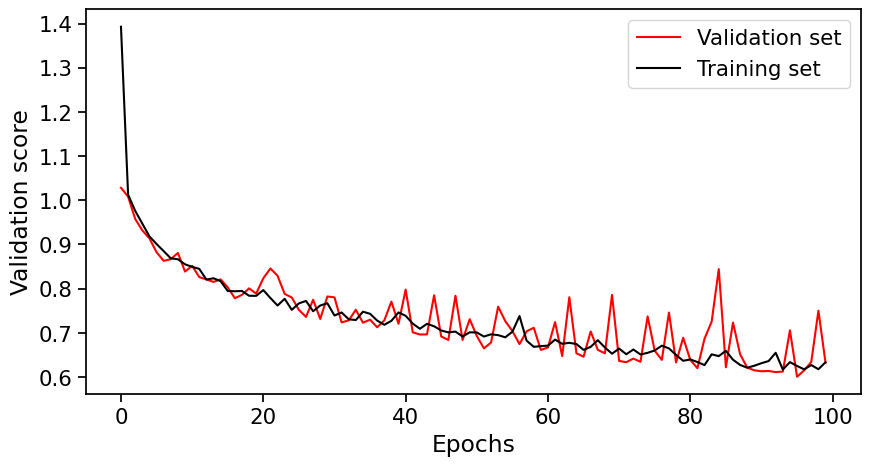

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1280)]            0         
                                                                 
 dense (Dense)               (None, 200)               256200    
                                                                 
 D1 (Dropout)                (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 D2 (Dropout)                (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 296,601
Trainable params: 296,601
Non-trainable

In [34]:
# Train with best parameters (their original Hparameters + EMS encoding)

model_file = modelsPath+gene_name+"_N1_N2_1_NN_optimized_EMSencoding.h5"
print(model_file)

# try:
#     if recompute:raise
#     optimised_model = keras.models.load_model(model_file)
#     print("Found",model_file)
    
# except:
    
dropout_rate = 0.1

# create and fit model with best Hparams
optimised_model=make_model()    

early_stopping_monitor = EarlyStopping(patience=10)

checkpoint_filepath="./tmp_mdl_checkpoint"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True)

out = optimised_model.fit(predictors_train.values,target_train.values,
                            validation_data=(predictors_valid.values,target_valid.values),
                            epochs=100,
                            shuffle=True,
                            batch_size=100,
                            callbacks=[early_stopping_monitor,model_checkpoint_callback])

optimised_model.load_weights(checkpoint_filepath)

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('w')

plt.plot(out.history['val_loss'], 'r')
plt.plot(out.history['loss'], 'k')

plt.xlabel('Epochs')
plt.ylabel('Validation score')

plt.legend(("Validation set","Training set"))

plt.show()

optimised_model.save(model_file)

optimised_model.summary()


In [35]:
# takes a bit of time, as the model predicts 10 times each genotype

train_set_muts = sorted(list(flatten([ elt.split(":") for elt in df.loc[train_index,:][genotype_col].values.flatten()])))
train_set_muts_unique = sorted(list(set(train_set_muts)))
counts_in_training_set=Counter(train_set_muts)

#-------------------------------
predictions_=pd.DataFrame(np.concatenate([optimised_model.predict(predictors_valid.values) for i in range(10)],axis=1),
                          index=predictors_valid.index)

predictions_median=pd.DataFrame(np.median(predictions_,axis=1),
                                index=predictors_valid.index,
                                columns=["median"])

predictions_std=pd.DataFrame(predictions_.std(axis=1),
                             index=predictors_valid.index,
                             columns=["std"])

predictions_as_df = pd.concat([df.loc[valid_index,:][[genotype_col]],
                               predictions_median,
                               predictions_std],
                              axis=1)

# find for each validation genotype the mutation with the min number of occurences
predictions_as_df["min_nb_of_contexts"] = predictions_as_df[genotype_col].apply(lambda x:min([counts_in_training_set.get(elt,0) for elt in x.split(":")]))


148/148 [==============================] - 0s 2ms/step


In [36]:
plot_range=(1,5)
plot_clim=None

if gene_name=="amacGFP":
    plot_range=(2,5)
    plot_clim=(1,200)
elif gene_name=="avGFP":
    plot_range=(1.3,5)
    plot_clim=(1,1000)
elif gene_name=="cgreGFP":
    plot_range=(1.5,5)
    plot_clim=(1,300)
elif gene_name=="ppluGFP":
    plot_range=(2,5)
    plot_clim=(1,200)


r2 0.402


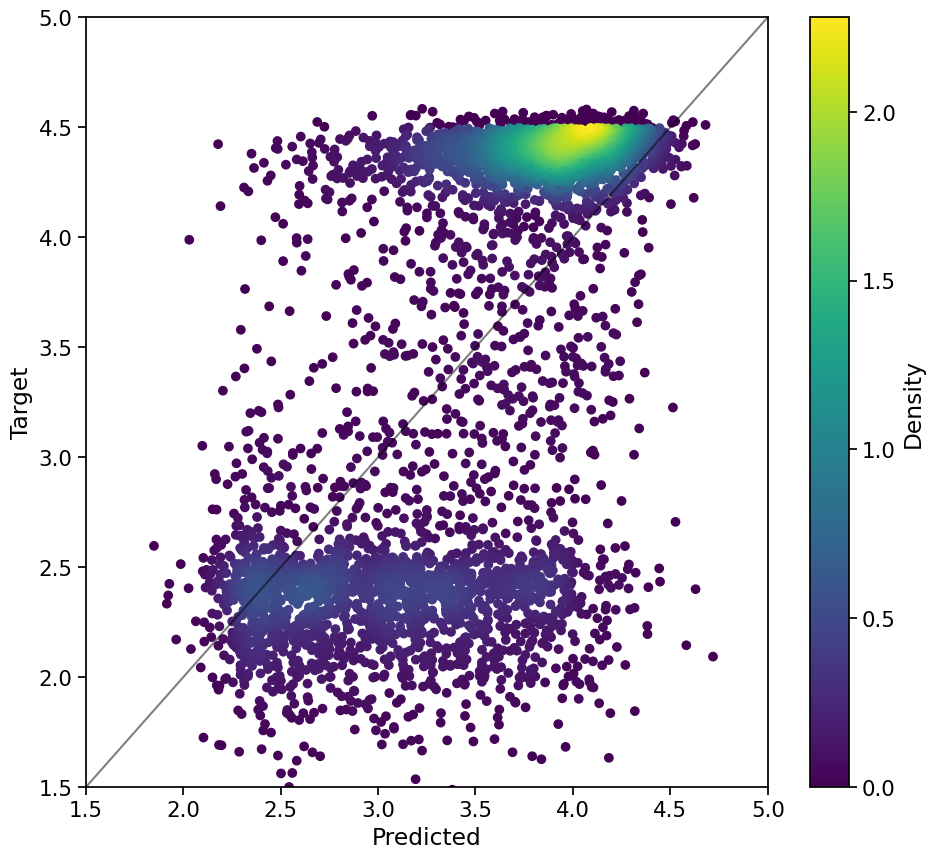

In [37]:

pred = predictions_median.values.flatten()
tar = target_valid.values.flatten()

r2_valid = r2_score(y_true=tar,y_pred=pred)
print("r2 %.3f" % r2_valid)

density_scatter(pred,tar, ax = None, sort = True, bins = 20)

plt.xlim(plot_range) 
plt.ylim(plot_range)  
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.plot(plot_range,plot_range,color="k",alpha=0.5)

plt.show()

